In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc


In [14]:
df = pd.read_csv("./MalBehavD-V1-dataset.csv/MalBehavD-V1-dataset.csv")
# Eliminar la columna 'sha256' 
df.drop(columns=['sha256'], inplace=True)
# Eliminar columnas vacías 
df.dropna(axis=1, how='all', inplace=True)
# Concatenar las secuencias de llamadas a API
df['api_sequence'] = df.iloc[:, 1:].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
df = df[['labels', 'api_sequence']]
df.head()

,labels,api_sequence
0,0,LdrUnloadDll CoUninitialize NtQueryKey NtDupli...
1,0,NtOpenMutant GetForegroundWindow NtQueryKey Dr...
2,0,GetForegroundWindow DrawTextExW GetSystemInfo ...
3,0,NtQueryValueKey LdrUnloadDll GlobalMemoryStatu...
4,0,LdrUnloadDll GetSystemTimeAsFileTime NtOpenKey...


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2570 entries, 0 to 2569
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        2570 non-null   int64 
 1   api_sequence  2570 non-null   object
dtypes: int64(1), object(1)
memory usage: 40.3+ KB



Distribución de clases en el dataset:


/tmp/ipykernel_46929/598033492.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['labels'], palette="coolwarm")


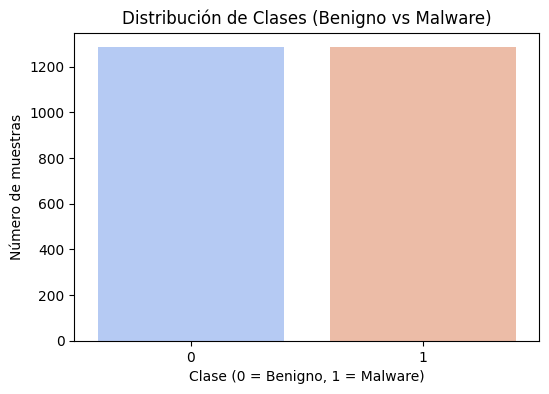


Resultados del Modelo Random Forest:
Accuracy: 0.9676
Precision: 0.9918
Recall: 0.9429


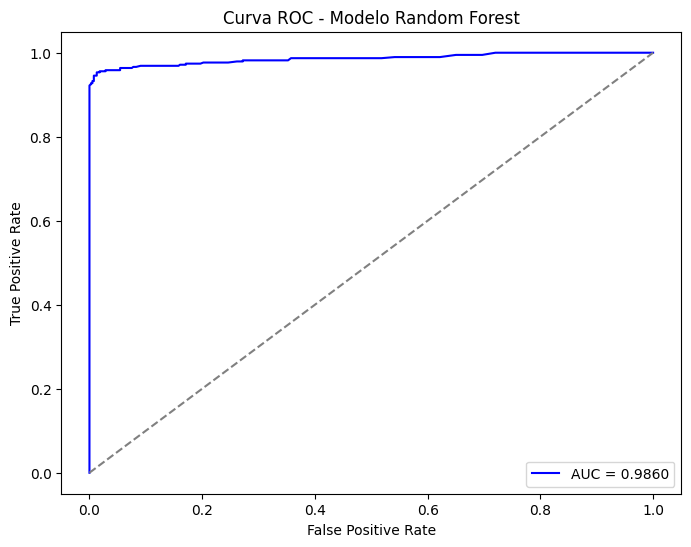


Cross-validation Accuracy (10 folds): 0.9646


In [34]:
# Preprocesamiento
# Eliminar la columna 'sha256' si existe
if 'sha256' in df.columns:
    df.drop(columns=['sha256'], inplace=True)

# Eliminar columnas completamente vacías
df.dropna(axis=1, how='all', inplace=True)

# Concatenar las secuencias de llamadas a API, asegurando que no haya NaN
df['api_sequence'] = df.iloc[:, 1:].astype(str).apply(lambda x: ' '.join(x.fillna('')), axis=1)

# Mantener solo columnas relevantes
df = df[['labels', 'api_sequence']]

# Convertir labels a entero
df['labels'] = df['labels'].astype(int)

# Ver distribución de clases
print("\nDistribución de clases en el dataset:")
df['labels'].value_counts(normalize=True)
# Visualizar distribución de clases
plt.figure(figsize=(6, 4))
sns.countplot(x=df['labels'], palette="coolwarm")
plt.title("Distribución de Clases (Benigno vs Malware)")
plt.xlabel("Clase (0 = Benigno, 1 = Malware)")
plt.ylabel("Número de muestras")
plt.show()

# Vectorización con TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")  # Agregamos eliminación de stopwords
X = vectorizer.fit_transform(df['api_sequence'])
y = df['labels']

# División del dataset en entrenamiento y prueba (70/30, estratificado)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Modelo de Machine Learning - Random Forest
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)  # Aumentamos estimadores y usamos múltiples núcleos
clf.fit(X_train, y_train)

# Predicción y evaluación
y_pred = clf.predict(X_test)

# Cálculo de métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\nResultados del Modelo Random Forest:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Curva ROC
y_probs = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Gráfica de la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Modelo Random Forest")
plt.legend()
plt.show()

# Validación cruzada (K-Folds = 10)
cv_scores = cross_val_score(clf, X, y, cv=10, n_jobs=-1)
print(f"\nCross-validation Accuracy (10 folds): {np.mean(cv_scores):.4f}")


1. Precisión del Modelo

    Accuracy (Precisión global): 96.76%
    Precision: 99.18%
    Recall: 94.29%
    Cross-validation Accuracy (10 folds): 96.46%

El modelo muestra un alto rendimiento, con una precisión del 96.76% y una validación cruzada de 96.46%, lo que indica que el modelo es consistente y generaliza bien en diferentes subconjuntos de datos.

2. Curva ROC & AUC

    AUC: 0.9860 (muy cercano a 1)
    La curva ROC muestra que el modelo tiene una gran capacidad de discriminación entre clases benignas y malware. Un AUC de 0.986 indica que el modelo tiene excelente capacidad predictiva.

3. Posible Sobreajuste

    Train Accuracy: No se muestra, pero si es mucho más alto que el Test Accuracy, podría indicar sobreajuste.
    Test Accuracy: 96.76% (muy alto, pero razonable)
    Validación cruzada: 96.46%

Conclusión sobre el sobreajuste:
No hay signos claros de overfitting. La validación cruzada tiene resultados similares a la prueba, lo que indica que el modelo generaliza bien.

Sin embargo, si la precisión en el conjunto de entrenamiento fuera cercana al 100%, entonces podríamos estar ante un posible sobreajuste, lo que podríamos mitigar reduciendo la complejidad del modelo.